En esta tarea de LDA y árboles de deicisón, trabajaremos con una base de datos obtenida de UCI Machine Learning Repository (debido a complicaciones de clasificación perfecta en base de datos de INEGI). La base de datos se llama 
Student Performance, la cual incluye una serie de información sobre alumnos, desde calificaciones, edad, escuela de procedencia, entre otras. 

1. Importamos los datos al ambiente de trabajo. Después, nos deshcaemos de las variables categóricas para dejar solamente variables numéricas para trabajar con la regresión más adelante. Creamos una variable target que vale uno cuando la nota final (G3) es mayor a 10 y 0 en caso contrario. Es decir, básicamente estamos tratando de clasificar entre alumnos que van a aprobar la materia y alumnos que no.  

In [1]:
import pandas as pd #importar librería
df=pd.read_csv("student.csv", sep=";") #leer archivo 
cols_no_num = df.select_dtypes(include=["object"]).columns # identificar columnas no numéricas
print("Columnas no numéricas:", cols_no_num.tolist())
df = pd.get_dummies(df, columns=cols_no_num, drop_first=True).astype(int)#convertir todas esas columnas a variables dummies
df["target"] = (df["G3"] > 10).astype(int) #creamos target
print(df.head()) #imprimimos primeras filas para revisar que todo esté en orden

Columnas no numéricas: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
   age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  goout  \
0   18     4     4           2          2         0       4         3      4   
1   17     1     1           1          2         0       5         3      3   
2   15     1     1           1          2         0       4         3      2   
3   15     4     2           1          3         0       3         2      2   
4   16     3     3           1          2         0       4         3      2   

   Dalc  ...  guardian_other  schoolsup_yes  famsup_yes  paid_yes  \
0     1  ...               0              1           0         0   
1     1  ...               0              0           1         0   
2     2  ...               0              1           0         0   
3     1  ...               0             

Separamos los datos en entrenamiento y prueba, asegurándonos que la proporción de clases se mantenga en train y test usando stratify. 

In [2]:
from sklearn.model_selection import train_test_split
x= df.drop(["G3", "target"], axis=1) # quitamos de las x las variables de salida
y = df["target"]  # definimos la variable de salida              
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, stratify=y, random_state=42
) #Separamos con un test 30%, train 70$% y mantenemos proporción
print("Observaciones en DF") #Revusamos observaciones y proporciones
print(df.target.value_counts())
print("Proporción en DF")
print(df.target.value_counts()/df.shape[0])
print("Observaciones en Y train")
print(y_train.value_counts())
print("Proporción en Y train")
print(y_train.value_counts()/y_train.shape[0])
print("Observaciones en Y test")
print(y_test.value_counts())
print("Proporción en Y test")
print(y_test.value_counts()/y_test.shape[0])

Observaciones en DF
target
1    452
0    197
Name: count, dtype: int64
Proporción en DF
target
1    0.696456
0    0.303544
Name: count, dtype: float64
Observaciones en Y train
target
1    316
0    138
Name: count, dtype: int64
Proporción en Y train
target
1    0.696035
0    0.303965
Name: count, dtype: float64
Observaciones en Y test
target
1    136
0     59
Name: count, dtype: int64
Proporción en Y test
target
1    0.697436
0    0.302564
Name: count, dtype: float64


2. Corremos una regresión logística simple con la función GLM de statsmodels con todas las variables de entrada e imprimos el resumen del modelo en consola. 

In [3]:
import statsmodels.api as sm
x_train = sm.add_constant(x_train)
model = sm.GLM(y_train, x_train, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  454
Model:                            GLM   Df Residuals:                      412
Model Family:                Binomial   Df Model:                           41
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -73.576
Date:                Tue, 30 Sep 2025   Deviance:                       147.15
Time:                        19:20:29   Pearson chi2:                     435.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.5952
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -26.1008      5.94

Las variables G2 y school_ms son las más importantes para la predicción, lo podemos notar por su p-value muy bajo, por lo tanto dejaremos en x train y test solamente estas dos variables para poder continuar con los demás pasos de la tarea. 

In [4]:
vars_importantes = ["G2", "school_MS"]
x_train = x_train[vars_importantes]
x_test= x_test[vars_importantes]

3. Generamos un modelo usando la metodología de linear discriminant analysis. 

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
ldaModel = LDA()
ldaModel.fit(x_train, y_train)
cl = ldaModel.predict(x_train)
print("Primeras 10 clases predichas:\n", cl[:10])

Primeras 10 clases predichas:
 [1 1 1 1 0 1 1 1 0 1]


Visualizamos la función discriminante con una gráfica de G2 vs school_MS. Graficamos como scatter los puntos de train, y dibujamos la línea donde se hace la partición entre clases, para poder ver cómo se comporta. 

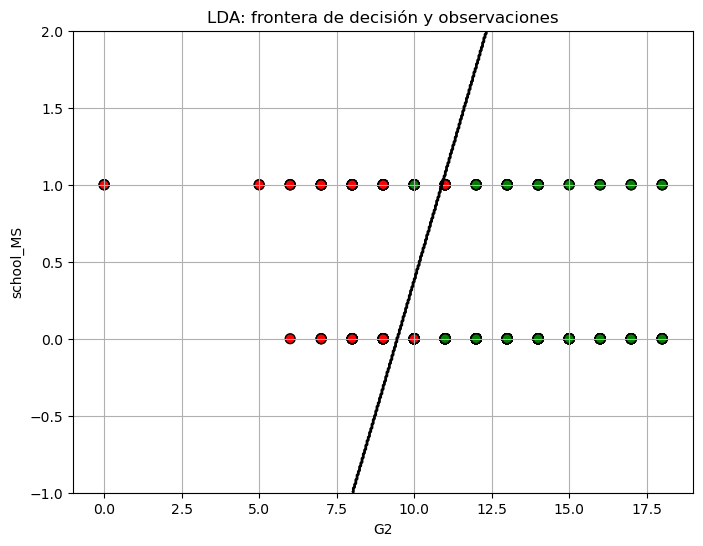

In [7]:
import numpy as np
import matplotlib.pyplot as plt
var1 = "G2"
var2 = "school_MS"
# Crear malla de puntos para graficar la función discriminante
x_min, x_max = x_train['G2'].min() - 1, x_train['G2'].max() + 1
y_min, y_max = x_train['school_MS'].min() - 1, x_train['school_MS'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Convertir malla a DataFrame con los mismos nombres de columnas que x_train
malla_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=x_train.columns)

# Predecir la clase para cada punto de la malla
Z = ldaModel.predict(malla_df)
Z = Z.reshape(xx.shape)

# Graficar
plt.figure(figsize=(8,6))

# Línea exacta de separación de LDA
plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)

# Puntos de entrenamiento según clase predicha
X_plot = x_train
y_plot = y_train
# Puntos reales con colores rojo y verde según la clase
colors = ['red' if val==0 else 'green' for val in y_plot]  # Ajusta 0 y 1 según las clases
plt.scatter(X_plot[var1], X_plot[var2], c=colors, edgecolor="k", s=50)


plt.xlabel('G2')
plt.ylabel('school_MS')
plt.title('LDA: frontera de decisión y observaciones')
plt.grid(True)
plt.show()


4. Generamos un modelo usando la metodología de árboles de decisión. Podamos el árbol, habiendo seleccionado primero un valor óptimo de 𝛼 mediante una metodología de LOOCV. 

In [8]:
from sklearn.tree import DecisionTreeClassifier as DTC
tree = DTC().fit(x_train, y_train) #Generamos el arbol
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
loo = LeaveOneOut()
cv_scores = []
ccp = np.linspace(0.01, 0.5, 250) #escogemos 250 valores de alpha que están entre 0.01 y 0.5
import time
start_time = time.time()  # inicia el contador
for alpha in ccp: #para cada alpha en el rango
    pruned_tree = DTC(ccp_alpha=alpha) #generamos el arbol podado
    cv_scores.append(np.mean(cross_val_score(pruned_tree, x_train, y_train, cv=loo, scoring='accuracy'))) #probamos la acuracy

alpha = ccp[np.argmax(cv_scores)]
print("Best alpha (LOOCV):", alpha) #escogemos la mejor accuracy encontrada
end_time = time.time()  # termina el contador
elapsed_time = end_time - start_time
print("Tiempo transcurrido (segundos):", elapsed_time)

Best alpha (LOOCV): 0.01
Tiempo transcurrido (segundos): 195.9641728401184


Podamos con alpha encontrada y visualizamos el árbol

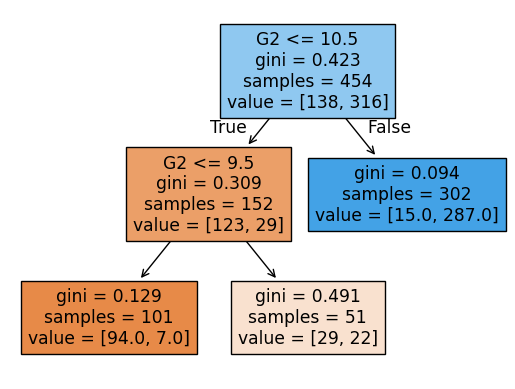

In [9]:
from sklearn.tree import plot_tree
pruned_tree = DTC(ccp_alpha=alpha).fit(x_train, y_train) #podamos el arbol con la mejor alpha
plot_tree(pruned_tree, filled=True, feature_names=x_train.columns); #graficamos el árbol 

Podemos ver que el árbol de decisión generará una partición en 10.5 y otra en 9.5. 
Visualizamos la partición en una gráfica de G2 vs school_MS

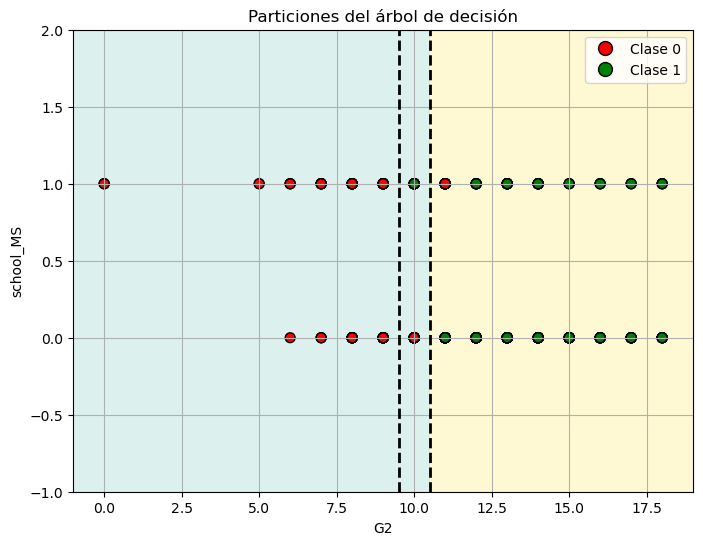

In [10]:

# Reentrenar árbol podado en estas 2 variables
tree_plot = DTC(ccp_alpha=alpha, random_state=42)
tree_plot.fit(X_plot, y_plot)

# Crear malla
x_min, x_max = X_plot[var1].min() - 1, X_plot[var1].max() + 1
y_min, y_max = X_plot[var2].min() - 1, X_plot[var2].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)

malla_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[var1, var2])
Z = tree_plot.predict(malla_df).reshape(xx.shape)

plt.figure(figsize=(8,6))

# Regiones de decisión
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set3)

# Puntos reales con colores rojo y verde según la clase
colors = ['red' if val==0 else 'green' for val in y_plot]  # Ajusta 0 y 1 según las clases
plt.scatter(X_plot[var1], X_plot[var2], c=colors, edgecolor="k", s=50)

# Leyenda
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Clase 0', markerfacecolor='red', markersize=10, markeredgecolor='k'),
    Line2D([0], [0], marker='o', color='w', label='Clase 1', markerfacecolor='green', markersize=10, markeredgecolor='k')
]
plt.legend(handles=legend_elements)

# Líneas de corte del árbol
plt.axvline(x=9.5, color="black", linestyle="--", linewidth=2)
plt.axvline(x=10.5, color="black", linestyle="--", linewidth=2)

plt.xlabel(var1)
plt.ylabel(var2)
plt.title("Particiones del árbol de decisión")
plt.grid(True)
plt.show()


5. Calculamos, para ambos modelos, todas las métricas revisadas en clase en los datos de prueba.

----- LDA -----
Accuracy: 0.897
Precision: 0.933
Sensitivity: 0.919
Specificity: 0.847
F1-score: 0.926


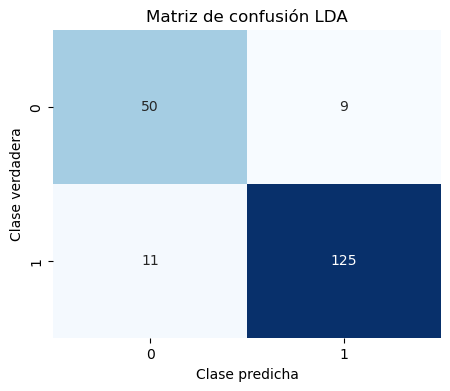

----- Árbol de Decisión -----
Accuracy: 0.892
Precision: 0.983
Sensitivity: 0.860
Specificity: 0.966
F1-score: 0.918


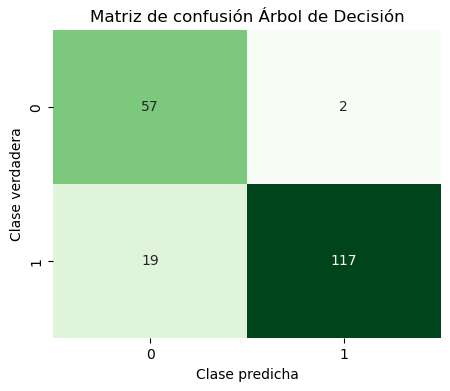

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)  # Esto es Sensitivity
    f1 = f1_score(y_true, y_pred)
    
    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn / (tn + fp)
    
    return acc, prec, rec, spec, f1

# ----- LDA -----
y_pred_lda = ldaModel.predict(x_test)
acc, prec, sens, spec, f1 = compute_metrics(y_test, y_pred_lda)
print("----- LDA -----")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Sensitivity: {sens:.3f}")
print(f"Specificity: {spec:.3f}")
print(f"F1-score: {f1:.3f}")

# Matriz de confusión LDA
cm_lda = confusion_matrix(y_test, y_pred_lda)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lda, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Clase predicha')
plt.ylabel('Clase verdadera')
plt.title('Matriz de confusión LDA')
plt.show()

# ----- Árbol de Decisión -----
y_pred_tree = pruned_tree.predict(x_test)
acc, prec, sens, spec, f1 = compute_metrics(y_test, y_pred_tree)
print("----- Árbol de Decisión -----")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Sensitivity: {sens:.3f}")
print(f"Specificity: {spec:.3f}")
print(f"F1-score: {f1:.3f}")

# Matriz de confusión Árbol de Decisión
cm_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(5,4))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Clase predicha')
plt.ylabel('Clase verdadera')
plt.title('Matriz de confusión Árbol de Decisión')
plt.show()
